In [39]:
%load_ext autoreload
%autoreload 2

from run_models import load_model
from DisruptionPredictors import DisruptionPredictorSM, DisruptionPredictorRF, DisruptionPredictorKM
from Experiments import Experiment
from plot_experiments import *

device = 'cmod'
#dataset_path = 'random_256_shots_60%_flattop'
dataset_path = 'random_2000_shots_50%_flattop'

# Load models and create disruption predictors

cph_model, cph_transformer, cph_features = load_model('cph', device, dataset_path)
cph_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_model, cph_features, cph_transformer)

dcph_model, dcph_transformer, dcph_features = load_model('dcph', device, dataset_path)
dcph_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_model, dcph_features, dcph_transformer)

dcm_model, dcm_transformer, dcm_features = load_model('dcm', device, dataset_path)
dcm_predictor = DisruptionPredictorSM("Deep Cox Mixture", dcm_model, dcm_features, dcm_transformer)

dsm_model, dsm_transformer, dsm_features = load_model('dsm', device, dataset_path)
dsm_predictor = DisruptionPredictorSM("Deep Survival Machines", dsm_model, dsm_features, dsm_transformer)

#rsf_model, rsf_transformer, rsf_features = load_model('rsf', device, dataset)
#rsf_predictor = DisruptionPredictorSM("Random Survival Forest", rsf_model, rsf_features, rsf_transformer)

dprf_model, dprf_transformer, dprf_features = load_model('dprf', device, dataset_path)
dprf_predictor = DisruptionPredictorRF("Random Forest", dprf_model, dprf_features, dprf_transformer)

km_model, km_transformer, km_features = load_model('dprf', device, dataset_path)
km_predictor = DisruptionPredictorKM("Kaplan-Meier", km_model, km_features, km_transformer)

# Create experiments for each predictor
cph_experiment = Experiment(device, dataset_path, cph_predictor, 'CPH')
dcph_experiment = Experiment(device, dataset_path, dcph_predictor, 'DCPH')
dcm_experiment = Experiment(device, dataset_path, dcm_predictor, 'DCM')
dsm_experiment = Experiment(device, dataset_path, dsm_predictor, 'DSM')
#rsf_experiment = Experiment(device, test_dataset, rsf_predictor, 'RSF')
dprf_experiment = Experiment(device, dataset_path, dprf_predictor, 'DPRF')
km_experiment = Experiment(device, dataset_path, km_predictor, 'KM')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model from models/cmod/random_2000_shots_50%_flattop/cph.pkl
Loaded model from models/cmod/random_2000_shots_50%_flattop/dcph.pkl
Loaded model from models/cmod/random_2000_shots_50%_flattop/dcm.pkl
Loaded model from models/cmod/random_2000_shots_50%_flattop/dsm.pkl
Loaded model from models/cmod/random_2000_shots_50%_flattop/dprf.pkl
Loaded model from models/cmod/random_2000_shots_50%_flattop/dprf.pkl


c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disr

KeyboardInterrupt: 

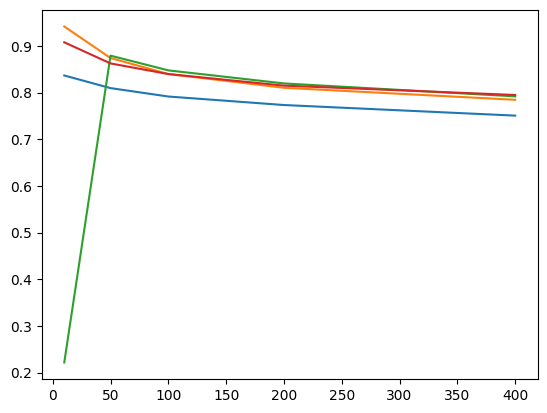

In [40]:
# Run the experiments
core_experiment_list = [cph_experiment, dcph_experiment, dcm_experiment, dsm_experiment, dprf_experiment, km_experiment]

plot_roc_auc_vs_horizon_micro(core_experiment_list)

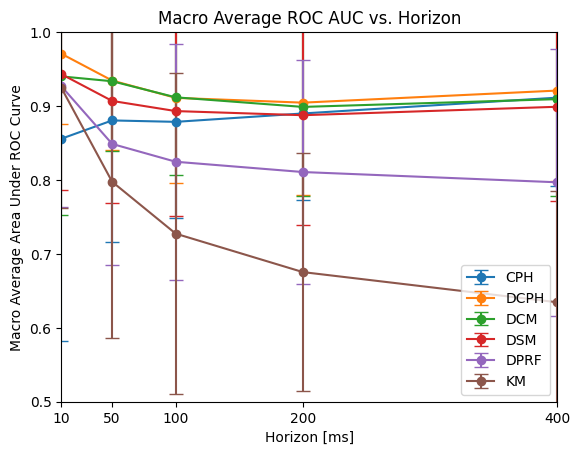

In [36]:
plot_roc_auc_vs_horizon_macro(core_experiment_list)

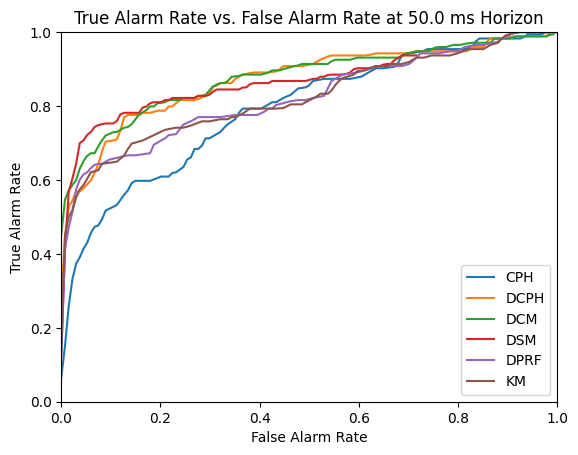

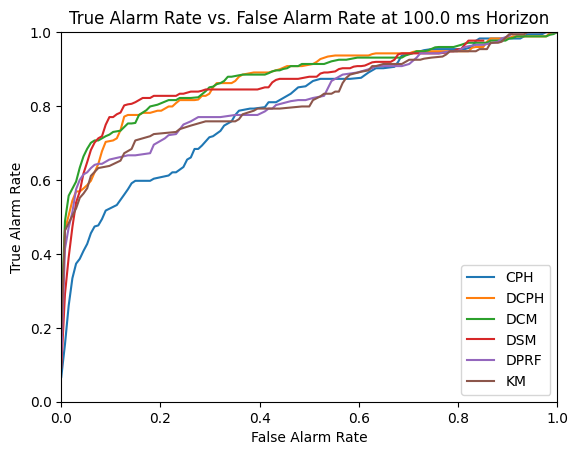

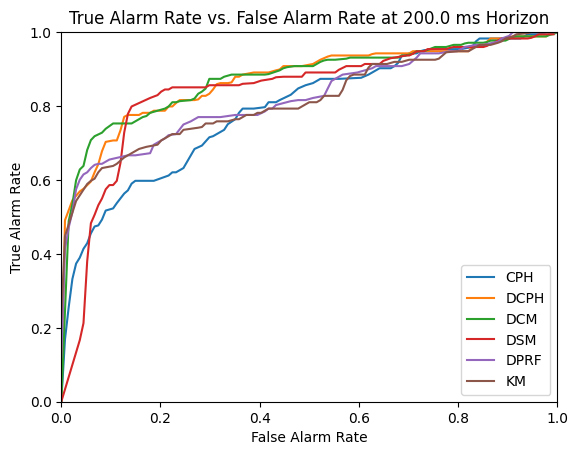

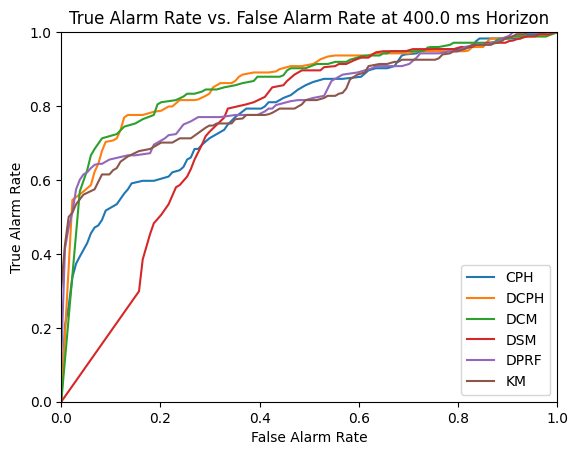

In [37]:
plot_TAR_vs_FAR(core_experiment_list, horizon=0.05)
plot_TAR_vs_FAR(core_experiment_list, horizon=0.1)
plot_TAR_vs_FAR(core_experiment_list, horizon=0.2)
plot_TAR_vs_FAR(core_experiment_list, horizon=0.4)

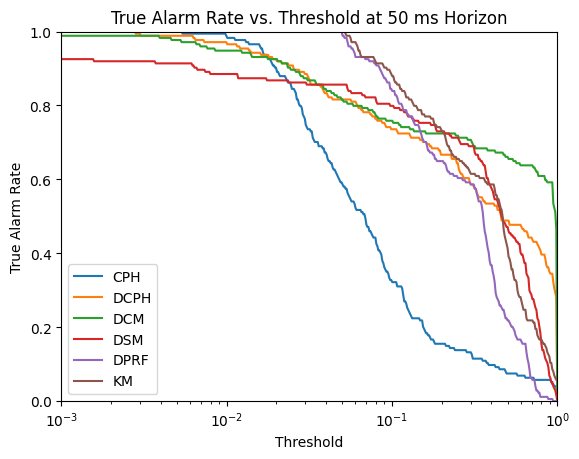

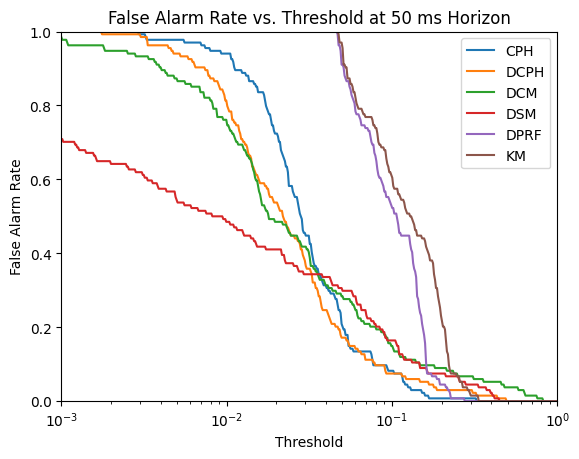

In [5]:
plot_TAR_vs_threshold(core_experiment_list, horizon=0.05)
plot_FAR_vs_threshold(core_experiment_list, horizon=0.05)

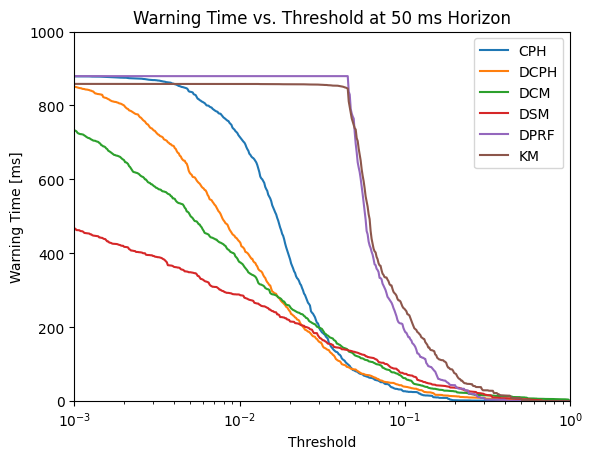

In [6]:
plot_warning_time_vs_threshold(core_experiment_list, 0.05)

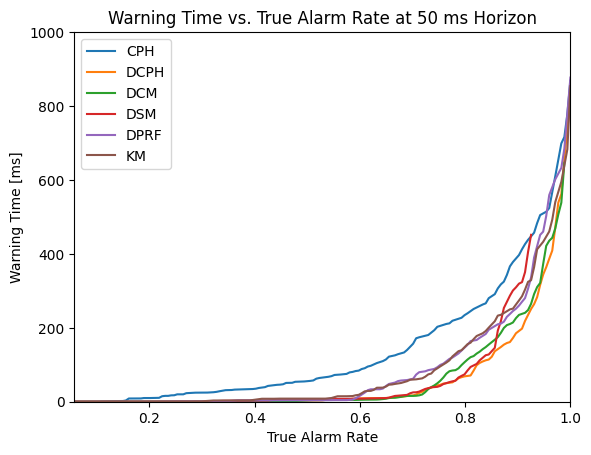

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:209: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  


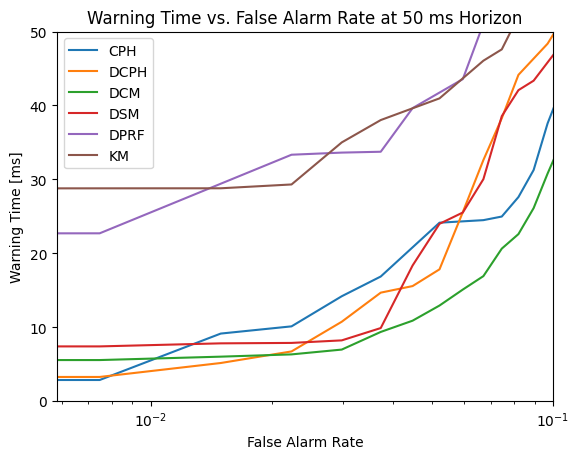

In [10]:
plot_warning_time_vs_TAR(core_experiment_list, 0.05)
plot_warning_time_vs_FAR(core_experiment_list, 0.05)

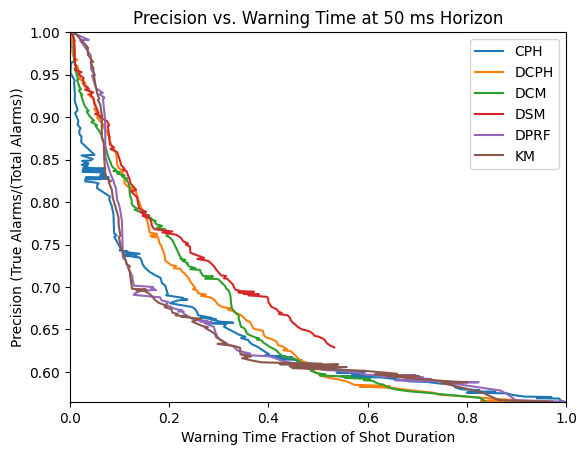

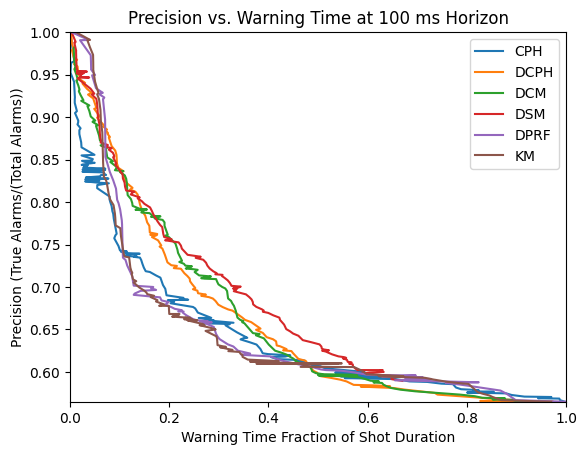

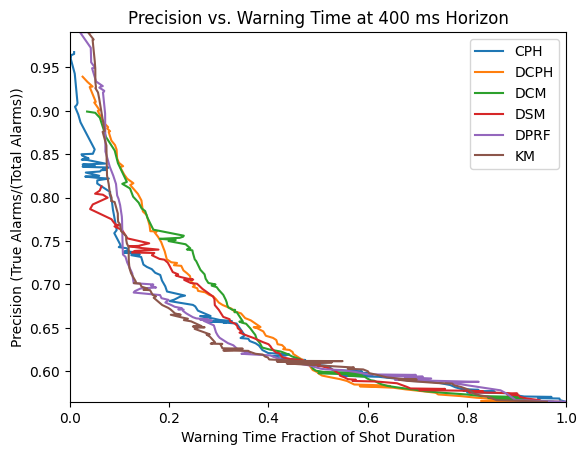

In [23]:
plot_warning_time_vs_precision(core_experiment_list, 0.05, scaled=True)
plot_warning_time_vs_precision(core_experiment_list, 0.1, scaled=True)
plot_warning_time_vs_precision(core_experiment_list, 0.4, scaled=True)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:250: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([min_missed_alarm_rate, max_missed_alarm_rate])


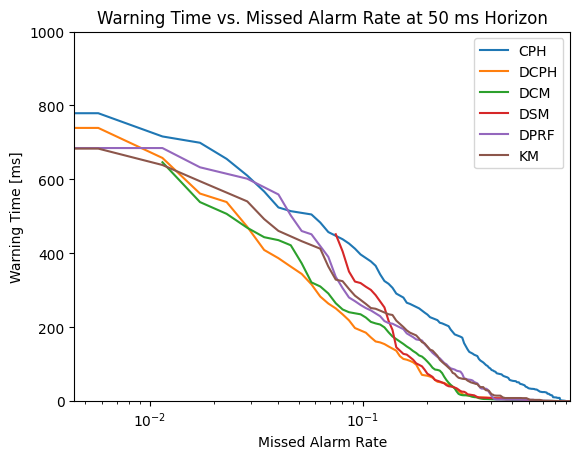

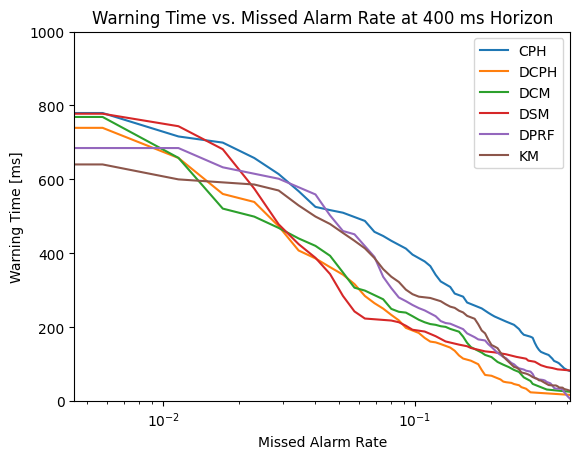

In [7]:
plot_warning_time_vs_missed_alarm_rate(core_experiment_list, 0.05)
plot_warning_time_vs_missed_alarm_rate(core_experiment_list, 0.4)

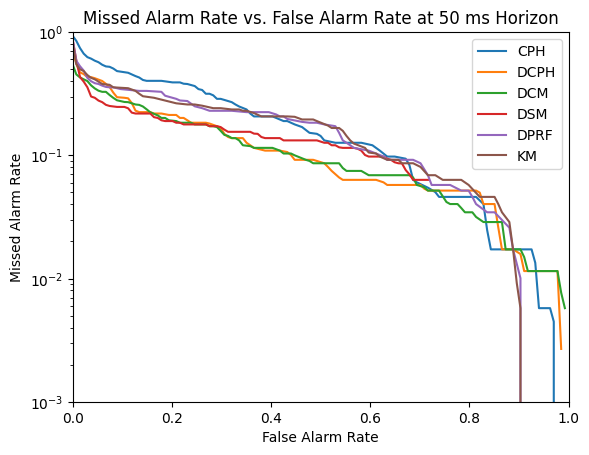

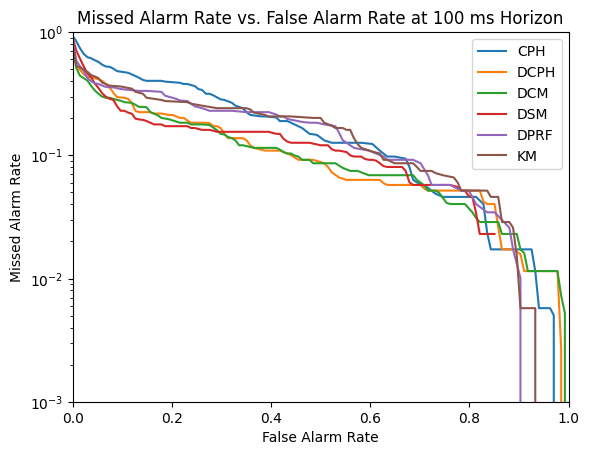

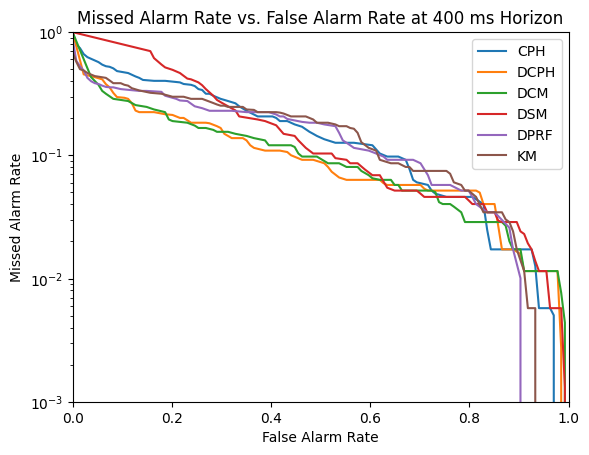

In [ ]:
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.01)
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.05)
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.1)
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.4)

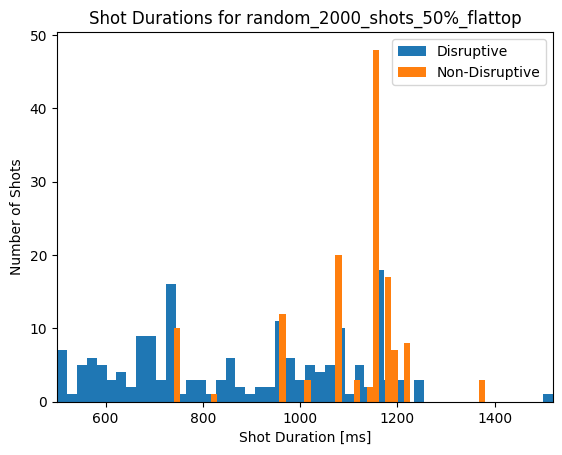

IndexError: index 174 is out of bounds for axis 0 with size 174

In [28]:
plot_disruptive_vs_non_disruptive_shot_durations(core_experiment_list[0])